## EN-2550 Assignment 2
## Index - 190521G
# Git Hub link :- 

### 1)

C:\Users\Lathika\AppData\Local\Temp\ipykernel_28920\2866390358.py:35: RuntimeWarning: invalid value encountered in double_scalars
  x_c = (det_2/det_1)/(-2)
C:\Users\Lathika\AppData\Local\Temp\ipykernel_28920\2866390358.py:36: RuntimeWarning: invalid value encountered in double_scalars
  y_c = (det_3/det_1)/(-2)
C:\Users\Lathika\AppData\Local\Temp\ipykernel_28920\2866390358.py:37: RuntimeWarning: invalid value encountered in double_scalars
  r = np.sqrt(x_c**2 + y_c**2 - (det_4/det_1))


'Referance\nhttps://sdg002.github.io/ransac-circle/index.html\nhttps://github.com/anubhavparas/ransac-implementation\nhttps://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html\n\n'

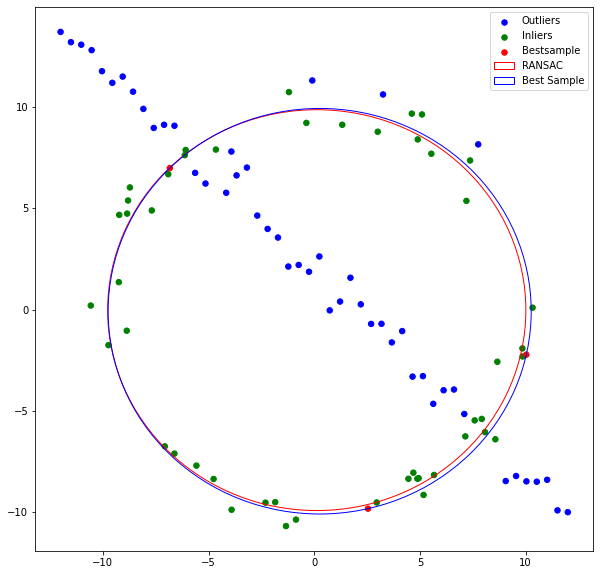

In [12]:
import numpy as np
from scipy import optimize
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
# np . random . seed ( 0 )
N = 100
half_n = N// 2
r = 10
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b =-1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )
X = np.round(X, 4)


# get circle from 3 points
def get_circle(x1,y1, x2,y2, x3,y3):
    x1y1 =x1**2 +y1**2
    x2y2 =x2**2 +y2**2
    x3y3 =x3**2 +y3**2

    mat = np.array([[x1y1, x1, y1, 1],[x2y2, x2, y2, 1],[x3y3, x3, y3, 1]])
    det_1 = np.round(np.linalg.det(np.hstack((mat[:,1].reshape(3,1),mat[:,2].reshape(3,1),mat[:,3].reshape(3,1)))) ,5)
    det_2 =  np.round(-np.linalg.det(np.hstack((mat[:,0].reshape(3,1),mat[:,2].reshape(3,1),mat[:,3].reshape(3,1)))) ,5)
    det_3 =  np.round(np.linalg.det(np.hstack((mat[:,0].reshape(3,1),mat[:,1].reshape(3,1),mat[:,3].reshape(3,1)))) ,5)
    det_4 =  np.round(-np.linalg.det(np.hstack((mat[:,0].reshape(3,1),mat[:,1].reshape(3,1),mat[:,2].reshape(3,1)))) ,5)

    x_c = (det_2/det_1)/(-2)
    y_c = (det_3/det_1)/(-2)
    r = np.sqrt(x_c**2 + y_c**2 - (det_4/det_1))

    return [x_c, y_c, r]


# get a candidate circle

def candidate_circle(X):

    x,y =X[:,0],X[:,1]

    x_m = np.mean(x)
    y_m = np.mean(y)

    def calc_R(xc, yc):
        #calculate the distance of each 2D points from the center (xc, yc)
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        # calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)
        Ri = calc_R(*c)
        return Ri - np.mean(Ri)

    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc, yc = center_2
    Ri         = calc_R(*center_2)
    R        = np.mean(Ri)

    return ([xc,yc,R])


# ransac circle

def Ransac_Circle(X , threshold, inliners_min_limmit, max_iterations, N, expecting_redius):
    iteretions=0
    inliner_list=[]     # element-->[num of inlinners, error, inliner points list, candidate circle(x0,y0,r), best_sample(point index),best sample  circle(x0,y0,r)]
    while (max_iterations> iteretions):
        a, b, c = [np.random.randint(0,N) for i in range(3)]

        x_c, y_c, r =  get_circle(X[a,0],X[a,1],X[b,0],X[b,1],X[c,0],X[c,1])

        if (np.absolute(r- expecting_redius)> 2*threshold):
            iteretions+=1
            continue

        err_array = np.square(np.sqrt((np.square(X[:,0].reshape(N,1) - x_c))+(np.square(X[:,1].reshape(N,1) - y_c))) - r)

        threshold_sq = threshold**2
 
        inliners=[]
        
        for i in range(N):
            if (err_array[i]<= threshold_sq):
                inliners.append(list(X[i]))
            
        num_inliners= len(inliners)
        
        if (num_inliners < inliners_min_limmit):
            iteretions+=1
            continue
        
        #get candidate circle
        x_cc , y_cc, R_c = candidate_circle(np.array(inliners))

        # check new inliner count and calculate error
        inliner_err=0
        inliners =  []
        err_array_with_candidate = np.square(np.sqrt((np.square(X[:,0].reshape(N,1) - x_cc))+(np.square(X[:,1].reshape(N,1) - y_cc))) - R_c)
        for i in range(N):
            if (err_array_with_candidate[i]<= threshold_sq):
                inliners.append(list(X[i]))
                inliner_err += err_array_with_candidate[i]
        num_inliners= len(inliners)
        mean_err = inliner_err/num_inliners
        if (num_inliners < inliners_min_limmit):
            iteretions+=1
            continue
   
        inliner_list.append([num_inliners, mean_err, inliners, [x_cc,y_cc,R_c], [a,b,c], [x_c, y_c, r ]])

        iteretions+=1

    return inliner_list


# choose the best match
best_index=0
max_inliners=0
min_err=1000
iterations =100
threshold =1
Min_Inliers_limit = 40

inliner_list = Ransac_Circle(X, threshold, Min_Inliers_limit,iterations,N, r)
for i in range(len(inliner_list)-1):
    if (max_inliners < inliner_list[i][0]):
        max_inliners= inliner_list[i][0]
        min_err = inliner_list[i][1]
        best_index = i
    elif (max_inliners == inliner_list[i][0]) and (min_err > inliner_list[i][1]):
        min_err = inliner_list[i][1]
        best_index = i

# seperate plotting points

inliners = inliner_list[best_index][2]
outliners =[]
for i in range(N):
    if (list(X[i]) not in inliners) :
        outliners.append(list(X[i]))
best_samples =[list(X[inliner_list[best_index][4][0]]), list(X[inliner_list[best_index][4][1]]), list(X[inliner_list[best_index][4][2]])]


for i in range(3):
    inliners.remove(best_samples[i])
    
#ploting
#ploting the dot diagrams
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(np.array(outliners)[:,0],np.array(outliners)[:,1],s= np.ones(len(outliners))*30 , color= 'blue', label = 'Outliers')
plt.scatter(np.array(inliners)[:,0],np.array(inliners)[:,1],s= np.ones(len(inliners))*30, color= 'green', label = 'Inliers')
plt.scatter(np.array(best_samples)[:,0],np.array(best_samples)[:,1],s= np.ones(len(best_samples))*30 , color= 'red', label = 'Bestsample')
#ploting circles
x_cc,y_cc,R_c = inliner_list[best_index][3]
RANSAC_circle = plt.Circle((x_cc , y_cc), R_c, fill=False , color = 'red' ,label='RANSAC')
ax.add_artist(RANSAC_circle)

x_c, y_c, r = inliner_list[best_index][5]
Best_Sample_circle = plt.Circle((x_c , y_c), r, fill=False , color = 'blue' ,label='Best Sample')
ax.add_artist(Best_Sample_circle)

plt.legend()


"""Referance
https://sdg002.github.io/ransac-circle/index.html
https://github.com/anubhavparas/ransac-implementation
https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html

"""


Ransac_Circle function is used to get an list of possible samples which satisfy the minimum inlier requierment. In the retuerning list element, there are 6 components.
1) Num of inliers
2) Average error
3) Inlier points as a list
4) Candidate circle (the circle corresponds to the samples)
5) Best sample ( The 3 sample points used to comput the initial circle)
6) Best sample circle (Circle computed by chosen inliers)

After the RANSAC function best matching linliers set is computerd by sorting. Fiest priority is givet to the element with the highest number of inliers. If there are two sets with the same number of inliers, then the second priority is given by the minimum average error.
After selecting the best set of inliers, then a avarage circle is computed as "RANSAC_circle"
This method can be used to select the best matching points in any kind of data set and do the computations with thoes inliers. It increase the accuracy as well. 

### 2 )

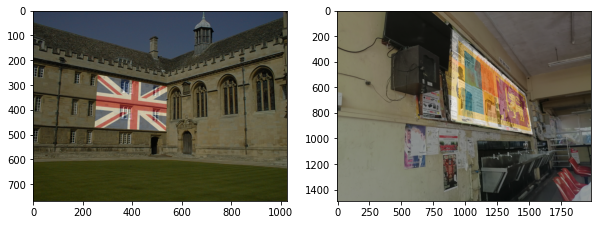

'\nhttps://www.etutorialspoint.com/index.php/319-python-opencv-overlaying-or-blending-two-images\nhttps://learnopencv.com/homography-examples-using-opencv-python-c/\nhttps://theailearner.com/tag/cv2-warpperspective/\nhttps://towardsdatascience.com/image-processing-with-python-applying-homography-for-image-warping-84cd87d2108f\n\n'

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


#load images 
flag = cv.cvtColor(cv.imread(r'Images\Flag_of_the_United_Kingdom.png'), cv.COLOR_BGR2RGB)
wall = cv.cvtColor(cv.imread(r'Images\002.jpg'), cv.COLOR_BGR2RGB)

flag2 = cv.cvtColor(cv.imread(r'Images\sl_flag.png'), cv.COLOR_BGR2RGB)
wall2 = cv.cvtColor(cv.imread(r'Images\Wall 2.jpeg'), cv.COLOR_BGR2RGB)

# interesting points
flag_pts = np.array([[0,0],[383,0],[383,192],[0,192]])
wall_pts = np.array([[261,260],[541,308],[536,487],[248,472]])

flag2_pts = np.array([[0,0],[860,0],[860,470],[0,470]])
wall2_pts = np.array([[902,148],[1472,656],[1530,970],[890,863]])


def get_projection(wall,flag,wall_pts,flag_pts):
    # getting homofraphy
    h, status = cv.findHomography(flag_pts, wall_pts)

    # get transformed image
    transformed_img =  cv.warpPerspective(flag, h,(wall.shape[1],wall.shape[0]))

    #blending images
    blended =cv.addWeighted(wall, 0.6, transformed_img,0.4,0)

    return blended

#show
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(get_projection(wall,flag,wall_pts,flag_pts))
ax[1].imshow(get_projection(wall2,flag2,wall2_pts,flag2_pts))
plt.show()

#reference
"""
https://www.etutorialspoint.com/index.php/319-python-opencv-overlaying-or-blending-two-images
https://learnopencv.com/homography-examples-using-opencv-python-c/
https://theailearner.com/tag/cv2-warpperspective/
https://towardsdatascience.com/image-processing-with-python-applying-homography-for-image-warping-84cd87d2108f

"""

### 3)